In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile("/content/drive/MyDrive/Dataset.zip", 'r')
zip_ref.extractall("/content/Dataset")
zip_ref.close()

##**Importing Libraries**


In [2]:
# Provides support for large, multi-dimensional arrays and matrices, as well as a wide range of mathematical functions
# We will be using this library to initialize our maze.
import numpy as np
import os
import joblib
from scipy.sparse import dok_matrix
# A 2D plotting library that enables users to create a wide variety of high-quality plots and visualizations.
# We will be using this library to display our maze in a visually appealing way.
import matplotlib.pyplot as plt

# A library that provides various functions for working with time-related operations. We will be using this library
# to give us time to look at how the agent is progressing through the maze
import time
import pickle


##**Creating the Maze Environment**

The code below sets up a simple maze with walls, a starting point (S), and a goal point (G). The maze is set up on a grid where each cell is either a 0 or 1, with 0 representing a black empty space and 1 representing a white wall.

In [3]:
class Maze:
    def __init__(self, maze, start_position, goal_position):
        # Initialize Maze object with the provided maze, start_position, and goal position
        self.maze = maze
        self.maze_height = maze_layout.shape[0] # Get the height of the maze (number of rows)

        self.maze_width = maze_layout.shape[1]  # Get the width of the maze (number of columns)
        self.start_position = start_position    # Set the start position in the maze as a tuple (x, y)
        self.goal_position = goal_position      # Set the goal position in the maze as a tuple (x, y)

    def show_maze(self):
        # Visualize the maze using Matplotlib
        plt.figure(figsize=(5,5))

        # Display the maze as an image in grayscale ('gray' colormap)
        plt.imshow(self.maze, cmap='gray')

        # Add start and goal positions as 'S' and 'G'
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

        # Remove ticks and labels from the axes
        plt.xticks([]), plt.yticks([])

        # Show the plot
        plt.show()



In [4]:

from PIL import Image

def generate_matrix(image_path):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    gray_image = image.convert("L")

    # Define the block size (20x20 pixels)
    block_size = 20
    num_blocks = gray_image.size[0] // block_size  # Number of blocks (21x21)

    # Initialize the matrix
    mapped_matrix = np.zeros((num_blocks, num_blocks), dtype=int)

    # Process each block
    for i in range(num_blocks):
        for j in range(num_blocks):
            # Get the coordinates of the block
            block = gray_image.crop((j * block_size, i * block_size, (j + 1) * block_size, (i + 1) * block_size))

            # Calculate the average color in the block
            avg_color = np.mean(block)

            # If the average color is closer to white (255), mark the block as 1, else 0
            mapped_matrix[i, j] = 1 if avg_color > 128 else 0

    return mapped_matrix




In [ ]:
#maze_layout=generate_matrix(f"E:/Major_project/Major Project/Major Project/Final_model/archive/rectangular_mazes/{iter}.png")
# Create an instance of the maze and set the starting and ending positions
#maze = Maze(maze_layout, (0, 1), (20, 19))
# Visualize the maze
# print(maze_layout[0,1])
# maze.show_maze()

##**Implementing the Agent**

The code below is for the agent. The agent can move in four directions: up, down, left, and right.

In [5]:
# Actions the agent can take: Up, Down, Left, Right. Each action is represented as a tuple of two values: (row_change, column_change)
actions = [(-1, 0), # Up: Moving one step up, reducing the row index by 1
          (1, 0),   # Down: Moving on step down, increasing the row index by 1
          (0, -1),  # Left: Moving one step to the left, reducing the column index by 1
          (0, 1)]   # Right: Moving one step to the right, increasing the column index by 1

class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        # Initialize the Q-learning agent with a Q-table containing all zeros
        # where the rows represent states, columns represent actions, and the third dimension is for each action (Up, Down, Left, Right)
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) # 4 actions: Up, Down, Left, Right
        self.learning_rate = learning_rate          # Learning rate controls how much the agent updates its Q-values after each action
        self.discount_factor = discount_factor      # Discount factor determines the importance of future rewards in the agent's decisions
        self.exploration_start = exploration_start  # Exploration rate determines the likelihood of the agent taking a random action
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def save_model(self, file_path='q_table.pkl'):
        with open(file_path, 'wb') as file:
            pickle.dump(self.q_table, file)
        # print(f"Q-table saved to {file_path}")

    # Method to load the model (Q-table)
    def load_model(self, file_path='q_table.pkl'):
        with open(file_path, 'rb') as file:
            self.q_table = pickle.load(file)
        # print(f"Q-table loaded from {file_path}")

    def get_exploration_rate(self, current_episode):
        # Calculate the current exploration rate using the given formula
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode): # State is tuple representing where agent is in maze (x, y)
        exploration_rate = self.get_exploration_rate(current_episode)
        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) # Choose a random action (index 0 to 3, representing Up, Down, Left, Right)
        else:
            return np.argmax(self.q_table[state]) # Choose the action with the highest Q-value for the given state

    def update_q_table(self, state, action, next_state, reward):
        # Find the best next action by selecting the action that maximizes the Q-value for the next state
        best_next_action = np.argmax(self.q_table[next_state])

        # Get the current Q-value for the current state and action
        current_q_value = self.q_table[state][action]

        # Q-value update using Q-learning formula
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Update the Q-table with the new Q-value for the current state and action
        self.q_table[state][action] = new_q_value



##**Defining the Reward System**

This code determines the values for the reward system. The reward system provides feedback to the agent in reinforcement learning.

Use these default settings to see how the agent performs when untrained, and when initially trained.

In [6]:
goal_reward = 100
wall_penalty = -10
step_penalty = -1

print("The reward system has been defined.")

The reward system has been defined.


## **Testing the Agent**

The code below tests how well the agent navigates the maze. It reports the total number of steps the agent took to get through the maze as well as the total reward the agent accumulated.


In [7]:
# This function simulates the agent's movements in the maze for a single episode.

def finish_episode(agent, maze, current_episode, train=True):
    # Initialize the agent's current state to the maze's start position
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    # Continue until the episode is done
    while not is_done:
        # Get the agent's action for the current state using its Q-table
        action = agent.get_action(current_state, current_episode)

        # Compute the next state based on the chosen action
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Check if the next state is out of bounds or hitting a wall
        if next_state[0] < 1 or next_state[0] >= maze.maze_height or next_state[1] < 1 or next_state[1] >= maze.maze_width or maze.maze[next_state[1]][next_state[0]] == 0:
            reward = wall_penalty
            next_state = current_state
        # Check if the agent reached the goal:
        elif next_state == (maze.goal_position):
            path.append(current_state)
            reward = goal_reward
            is_done = True
        # The agent takes a step but hasn't reached the goal yet
        else:
            path.append(current_state)
            reward = step_penalty

        # Update the cumulative reward and step count for the episode
        episode_reward += reward
        episode_step += 1

        # Update the agent's Q-table if training is enabled
        if train == True:
            agent.update_q_table(current_state, action, next_state, reward)

        # Move to the next state for the next iteration
        current_state = next_state

    # Return the cumulative episode reward, total number of steps, and the agent's path during the simulation
    return episode_reward, episode_step, path



##**Setting Up the Reinforcement Learning Loop**

In [8]:
def train_agent(agent, maze, num_episodes=100):
    # Lists to store the data for plotting
    episode_rewards = []
    episode_steps = []

    # Loop over the specified number of episodes
    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze, episode, train=True)

        # Store the episode's cumulative reward and the number of steps taken in their respective lists
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

    # Plotting the data after training is completed
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')

    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"The average reward is: {average_reward}")

    plt.subplot(1, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.ylim(0, 100)
    plt.title('Steps per Episode')

    average_steps = sum(episode_steps) / len(episode_steps)
    print(f"The average steps is: {average_steps}")

    plt.tight_layout()
    # plt.show()
    return average_steps, average_reward

print("This code block has been run and the train_agent function is now available for use.")

This code block has been run and the train_agent function is now available for use.


In [9]:
# This function evaluates an agent's performance in the maze. The function simulates the agent's movements in the maze,
# updating its state, accumulating the rewards, and determining the end of the episode when the agent reaches the goal position.
# The agent's learned path is then printed along with the total number of steps taken and the total reward obtained during the
# simulation. The function also visualizes the maze with the agent's path marked in blue for better visualization of the
# agent's trajectory.

def test_agent(agent, maze, num_episodes=1):
    # Simulate the agent's behavior in the maze for the specified number of episodes
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=False)
    
    fpath=[]
    for row, col in path:
        # print(f"({row}, {col})-> ", end='')
        if(fpath.__contains__((row,col))):
            print()
        else:
            fpath.append((row,col))
        

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    # Clear the existing plot if any
    if plt.gcf().get_axes():
        plt.cla()

    # Visualize the maze using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(maze.maze, cmap='gray')

    # Mark the start position (red 'S') and goal position (green 'G') in the maze
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

    # Mark the agent's path with blue '#' symbols
    for position in path:
        plt.text(position[0], position[1], "*", va='center', color='blue', fontsize=20)

    # Remove axis ticks and grid lines for a cleaner visualization
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

    return fpath, episode_step, episode_reward


##**Training the Agent**

In [ ]:
# for i in range(0, 51):
#     # Training the agent
#     agent = QLearningAgent(maze)

#     average_steps, average_reward = train_agent(agent, maze, num_episodes=90000)
#     # agent.save_model('q_table1.pkl')
for iter in range(135, 200):
    # Training the agent
    maze_layout=generate_matrix(f"E:/Major_project/Major Project/Major Project/Final_model/archive/rectangular_mazes/{iter}.png")
    # Create an instance of the maze and set the starting and ending positions
    maze = Maze(maze_layout, (0, 1), (20, 19))
    # Visualize the maze
    # print(maze_layout[0,1])
    # maze.show_maze()
    agent = QLearningAgent(maze)

    average_steps, average_reward = train_agent(agent, maze, num_episodes=90000)
    with open("rewards.txt", "a") as file:
        file.write(f"{average_steps},{average_reward}\n")

In [ ]:
# Testing the agent after training
# agent = QLearningAgent(maze)
# agent.load_model('q_table1.pkl')
mypath, average_steps, average_reward =test_agent(agent, maze, num_episodes=100)
# mypath.remove((0,1))
print(mypath)


In [17]:
def generate_movement_instructions(path):

    instructions = []

    for i in range(len(path) - 1):
        start_x, start_y = path[i]
        end_x, end_y = path[i + 1]

        # Determine the direction and distance for this segment
        if start_x < end_x and start_y == end_y:  # Move forward
            direction = "forward"
            distance = end_x - start_x
        elif start_x == end_x and start_y < end_y:  # Turn right
            direction = "right"
            distance = end_y - start_y
        elif start_x == end_x and start_y > end_y:  # Turn left
            direction = "left"
            distance = start_y - end_y
        else:
            direction = "right"
            distance = start_x - end_x

        # Move in the determined direction
        while distance > 0:
            instructions.append(("moveForward"))
            distance -= 1

        # Turn if necessary for the next segment
        if i < len(path) - 2:
            next_x, next_y = path[i + 2]
            if direction == "forward" and next_y != end_y:
                instructions.append(("turnRight" if next_y > end_y else "turnLeft"))
            elif direction == "right" and next_x != end_x:
                instructions.append(("turnLeft"))
            elif direction == "left" and next_x != end_x:
                instructions.append(("turnRight"))

    return instructions

instructions = generate_movement_instructions(mypath)
with open('Path.txt','w') as file:
    file.write("\n".join(instructions))
print(instructions)

['moveForward', 'turnRight', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'turnLeft', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'turnRight', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'turnLeft', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'moveForward', 'turnLeft', 'moveForward', 'moveForward', 'turnRight', 'moveForward', 'moveForward', 'turnRight', 'moveForward', 'moveForward', 'turnLeft', 'moveForward', 'moveForward', 'moveForward', 'moveForward']


In [1]:
import websocket
import time

def on_message(ws, message):
    print("Received from ESP32: " + message)

def on_open(ws):
    # Open file in read mode
    with open('Path.txt', 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Send each line over the WebSocket connection
            print(f"Sending: {line.strip()}")
            ws.send(line.strip())  # Send the line to the ESP32

            # Optionally wait for a response from ESP32 before sending the next line
            time.sleep(5)  # Adjust sleep time as per your requirement

    # Close the WebSocket connection after sending all lines
    ws.close()

def on_error(ws, error):
    print(f"Error: {error}")

def on_close(ws, close_status_code, close_msg):
    print(f"WebSocket closed: {close_msg}")

# WebSocket client setup
ws = websocket.WebSocketApp(
    "ws://192.168.13.28:81",  # Replace with your ESP32 IP address
    on_message=on_message,
    on_error=on_error,
    on_close=on_close
)

# When the connection is opened, it will start sending data
ws.on_open = on_open

# Start the WebSocket client and keep it running
ws.run_forever()


Error: 
WebSocket closed: None


True

## Evaluatnig agent

In [ ]:
def evaluate_agent(agent, maze, num_episodes=100):
    total_rewards = []
    total_steps = []
    successful_episodes = 0
    exploration_count = 0
    exploitation_count = 0
    shortest_path_length = len(test_agent(agent, maze, num_episodes=1))  # Estimate the shortest path length based on trained model

    # Simulate multiple episodes
    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze, episode, train=False)

        # Append the rewards and steps for each episode
        total_rewards.append(episode_reward)
        total_steps.append(episode_step)

        # Check if the agent reached the goal in the episode (success)
        if path[-1] == maze.goal_position:
            successful_episodes += 1

        # Calculate the number of exploration vs exploitation actions
        exploration_rate = agent.get_exploration_rate(episode)
        if np.random.rand() < exploration_rate:
            exploration_count += 1
        else:
            exploitation_count += 1

    # Metrics Calculation
    cumulative_reward = sum(total_rewards) / num_episodes
    avg_episode_length = sum(total_steps) / num_episodes
    success_rate = (successful_episodes / num_episodes) * 100
    avg_path_efficiency = sum(len(path) for path in total_steps if path[-1] == maze.goal_position) / (successful_episodes * shortest_path_length)

    exploration_exploitation_ratio = exploration_count / exploitation_count

    print(f"Cumulative Reward: {cumulative_reward}")
    print(f"Average Episode Length: {avg_episode_length}")
    print(f"Success Rate: {success_rate}%")
    print(f"Path Efficiency: {avg_path_efficiency}")
    print(f"Exploration vs Exploitation Ratio: {exploration_exploitation_ratio}")

    return total_rewards, total_steps, exploration_count, exploitation_count

# Call the evaluation function after training
total_rewards, total_steps, exploration_count, exploitation_count = evaluate_agent(agent, maze, num_episodes=100)


## Rewards and steps graph

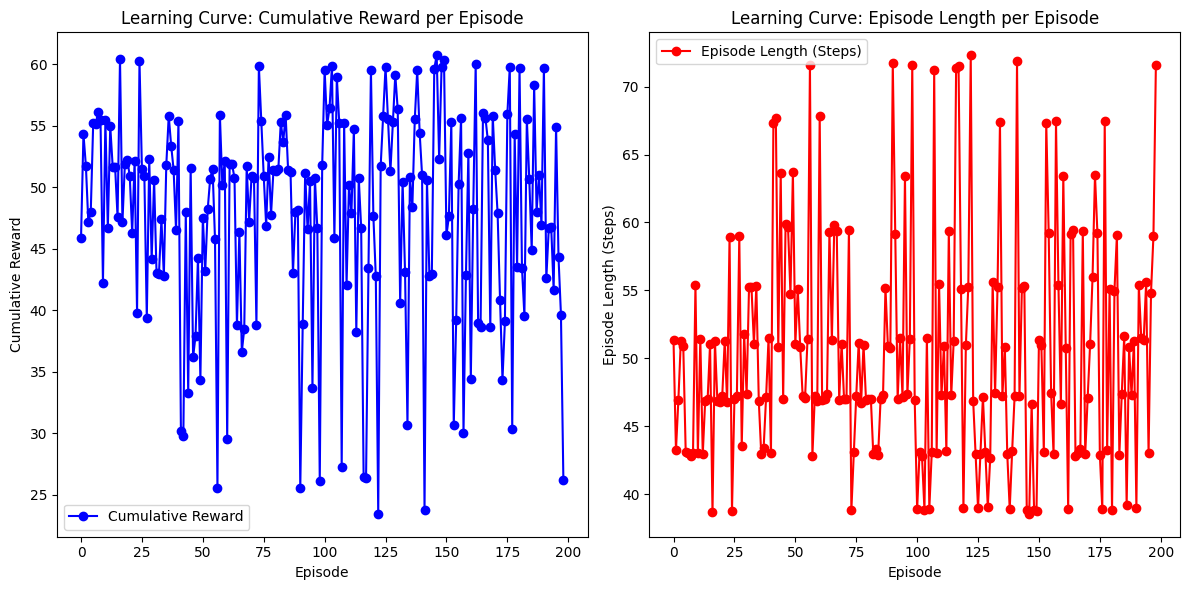

In [11]:
import matplotlib.pyplot as plt

# Function to read average_reward and average_steps from a file with multiple data points
def read_data_from_file(file_path):
    steps_list = []
    reward_list = []
    
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if line.strip():  # Skip empty lines
                    steps, reward = map(float, line.split(','))  # Split by comma and convert to floats
                    steps_list.append(steps)  # Append to the steps list
                    reward_list.append(reward)  # Append to the reward list
        return reward_list, steps_list
    except FileNotFoundError:
        print(f"File '{file_path}' not found!")
        return [], []

# Plotting function
def plot_learning_curve(total_rewards, total_steps):
    if not total_rewards or not total_steps:
        print("No data to plot!")
        return

    plt.figure(figsize=(12, 6))

    # Plot Cumulative Reward per Episode
    plt.subplot(1, 2, 1)
    plt.plot(total_rewards, color='blue', marker='o', label='Cumulative Reward')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Learning Curve: Cumulative Reward per Episode')
    plt.legend()

    # Plot Episode Length per Episode
    plt.subplot(1, 2, 2)
    plt.plot(total_steps, color='red', marker='o', label='Episode Length (Steps)')
    plt.xlabel('Episode')
    plt.ylabel('Episode Length (Steps)')
    plt.title('Learning Curve: Episode Length per Episode')
    plt.legend()

    plt.tight_layout()
    plt.draw()
    plt.show()

# Read the data from the file and plot the learning curve
file_path = 'rewards.txt'  # Specify the path to your text file
average_reward, average_steps = read_data_from_file(file_path)
plot_learning_curve(average_reward, average_steps)
